In [5]:
import pylab as pl
import matplotlib as plt
import numpy as np
import pandas as pd
import os
import urllib
import requests
import geopandas as gp
import shapely
from fiona.crs import from_epsg
import sklearn.preprocessing as preprocessing
#from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import RandomForestRegressor as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/mkm/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

## 1. Collect the school related data

**1.1 Collect School SAT data**

In [964]:
sat = pd.read_csv("https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD")

In [969]:
tmp_ = sat.iloc[:,-3:].convert_objects(convert_numeric=True)

/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [977]:
sat['SATall'] = tmp_.mean(axis=1)

In [979]:
sat = sat.rename(columns={'SAT Math Avg. Score':'SATmath'})

In [980]:
sat = sat[['DBN', 'SATmath', 'SATall']]
sat.to_csv("satScoresNYC.csv", index=False)
sat.head()

,DBN,SATmath,SATall
0,01M292,404,374.000000
1,01M448,423,390.666667
2,01M450,402,383.000000
3,01M458,401,391.333333
4,01M509,433,402.333333


In [1135]:
sat.shape

(478, 3)

**1.2 Collect School Crime data**

In [983]:
crime = pd.read_csv("https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD")
crime.head()

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2013-14,K001,15K001,P.S. 001 The Bergen,K001,309 47 STREET,K,15.0,"1,277",NaN,...,BROOKLYN,11220.0,40.649042,-74.012289,7.0,38.0,80.0,3011821.0,3.007550e+09,Sunset Park West ...
1,2013-14,K002,17K002,Parkside Preparatory Academy,K002,655 PARKSIDE AVENUE,K,17.0,479,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
2,2013-14,K002,75K141,P.S. K141,K141,655 PARKSIDE AVENUE,K,17.0,397,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
3,2013-14,K002,84K704,Explore Charter School,K704,655 PARKSIDE AVENUE,K,17.0,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
4,2013-14,K002,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,NaN,655 PARKSIDE AVENUE,K,17.0,876,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


In [984]:
crime.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', 'Location Code',
       'Address', 'Borough', 'Geographical District Code', 'Register',
       'Building Name', '# Schools', 'Schools in Building', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude', 'Community Board',
       'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

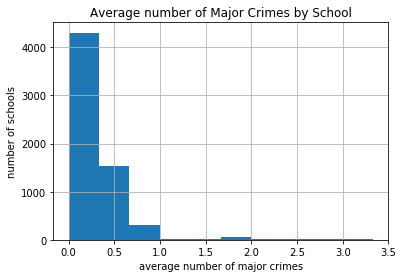

In [1125]:
cplot = crime[['AvgOfMajor N']].fillna(value=0)
cplot.hist()

pl.title('Average number of Major Crimes by School')
pl.ylabel("number of schools");
pl.xlabel("average number of major crimes");

**Fig.1** The histogram shows the distribution of average number of major crimes by schools. The distribution is skewed left, and the average number of major crimes of most schools is between 0 to 1.

## 2. Merge school crime and SAT data

**2.1 Merge the SAT and the crime in school data based on the school identifier.**

In [14]:
crimeschools = crime[['DBN','Major N', 'Oth N',
                   'NoCrim N', 'Prop N', 'Vio N','AvgOfMajor N',
                   'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude']]

In [15]:
crimeschools.fillna({'Major N':0, 'Oth N':0, 'NoCrim N':0, 'Prop N':0, 'Vio N':0,'AvgOfMajor N':0,
                   'AvgOfOth N':0, 'AvgOfNoCrim N':0, 'AvgOfProp N':0, 'AvgOfVio N':0}, inplace=True)

/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [991]:
crimeschools.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,15K001,0.0,2.0,1.0,1.0,0.0,0.86,3.26,5.55,2.17,1.29,40.649042,-74.012289
1,17K002,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.656183,-73.951583
2,75K141,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.656183,-73.951583
3,84K704,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.656183,-73.951583
4,NaN,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583


In [1148]:
satschools = pd.DataFrame(sat)

In [1149]:
schools = crimeschools.merge(sat, on='DBN')

In [1150]:
print("crime schools DF shape", crimeschools.shape, "SAT schools DF shape", satschools.shape)

crime schools DF shape (6310, 13) SAT schools DF shape (478, 3)


In [1151]:
schools = schools.drop_duplicates()

In [1152]:
schools['SATmath'] = pd.to_numeric(schools['SATmath'], errors='coerce')

In [1153]:
schools = schools[(schools.SATmath > 0 ) * (schools.SATall > 0)].dropna()

/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [1154]:
schools.shape

(648, 15)

In [1155]:
schools.to_csv("schoolsDF.csv", index=False)
print(schools.shape)
schools.head()

(648, 15)


,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATmath,SATall
0,16K393,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.692126,-73.931731,355.0,356.000000
3,02M418,0.0,0.0,0.0,0.0,0.0,0.33,1.32,1.76,0.83,0.59,40.704487,-74.011556,553.0,538.000000
4,02M418,0.0,0.0,0.0,0.0,0.0,0.31,1.12,1.82,0.79,0.51,40.704487,-74.011556,553.0,538.000000
5,02M418,0.0,0.0,0.0,0.0,0.0,0.28,1.11,1.74,0.75,0.53,40.704487,-74.011556,553.0,538.000000
9,16K594,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.680463,-73.922264,372.0,364.333333


**2.3 Count the individual school location: there may be multiple schools in a single building**

In [1002]:
schools['lonlat'] = list(zip(schools.Longitude, schools.Latitude))

In [1012]:
len(schools.groupby('lonlat').count())
print("The number of individual school locations is:" + str(len(schools.groupby('lonlat').count())))

The number of individual school locations is:258


Text(0.5, 0, 'number of building')

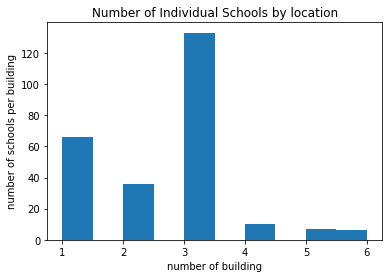

In [1019]:
pl.hist(schools.groupby('lonlat').count()[['DBN']].T)
pl.title('Number of Individual Schools by location')
pl.ylabel("number of schools per building");
pl.xlabel("number of building")

**Comment:** The number of individual school locations is reduced from 648 to 258. According to its distribution, most of building locations have 2 or more schools. Since the SAT data is averaged by DBN, this result implies that crime data is better to be average by DBN to compare with SAT data.

## 3. Visualize the school related data 

**3.1 plot the Math SAT score and the average of all SAT scores as a function of two crime statistics**

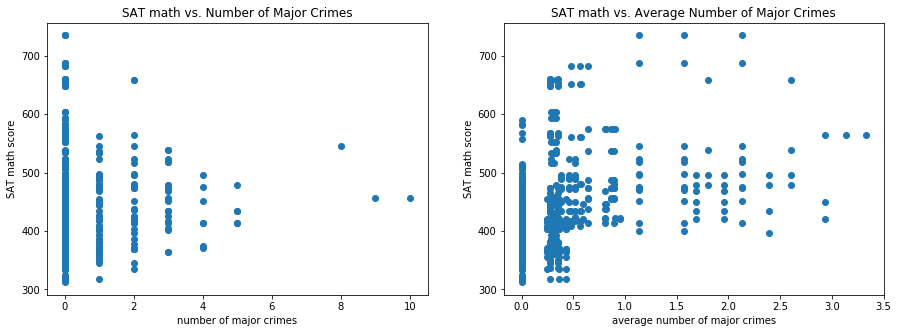

In [1026]:
fig = pl.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.scatter(schools['Major N'],schools['SATmath'])
ax1.set_title('SAT math vs. Number of Major Crimes')
ax1.set_ylabel("SAT math score");
ax1.set_xlabel("number of major crimes");

ax2 = fig.add_subplot(122)
ax2.scatter(schools['AvgOfMajor N'], schools['SATmath'])
ax2.set_title('SAT math vs. Average Number of Major Crimes')
ax2.set_ylabel("SAT math score");
ax2.set_xlabel("average number of major crimes");

**Fig. 3** The scatter plots show that the number of major crimes has no obvious correlation with SAT math scores, but the average number of major crimes has a sliglty positive correlation with SAT math scores.

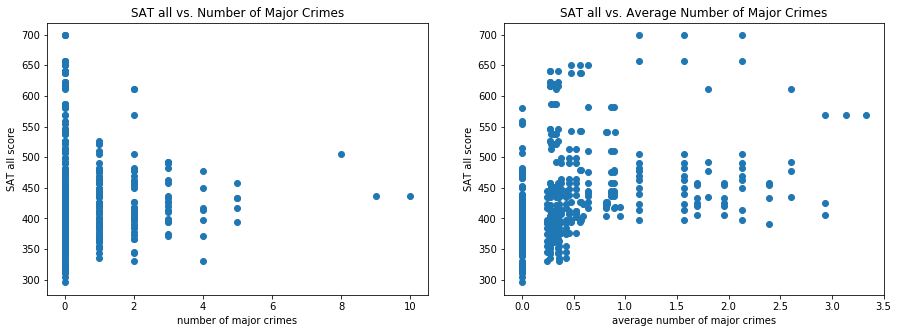

In [1021]:
fig = pl.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.scatter(schools['Major N'], schools['SATall'])
ax1.set_title('SAT all vs. Number of Major Crimes')
ax1.set_ylabel("SAT all score");
ax1.set_xlabel("number of major crimes");

ax2 = fig.add_subplot(122)
ax2.scatter(schools['AvgOfMajor N'],schools['SATall'])
ax2.set_title('SAT all vs. Average Number of Major Crimes')
ax2.set_ylabel("SAT all score");
ax2.set_xlabel("average number of major crimes");

**Fig. 4** The scatter plots show that the number of major crimes has no obvious correlation with average SAT all scores, but the average number of major crimes has a sliglty positive correlation with average SAT all scores.

**3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset**

In [1027]:
schools['geometry'] = schools[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [1028]:
schools = gp.GeoDataFrame(schools)

In [1029]:
schools.crs = from_epsg(4326)

In [1030]:
schools.to_crs(epsg=2263, inplace=True)

## 4. Gather Asthma and drugs hospital discharge

**4.1 read in the SPARCS data**

In [105]:
facilities = pd.read_csv('https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD')

In [1032]:
facilities.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,NaN,182357.0,NaN,NaN,0,N,Y,1108.20,1644.75
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3418.18,3370.87


In [1033]:
#facilities = facilities[facilities['Health Service Area'] == 'New York City']

In [1034]:
facilities.shape

(2544543, 37)

In [1035]:
facilities = facilities[(facilities['Hospital County'] == 'Manhattan') +\
            (facilities['Hospital County'] == 'Queens') +\
            (facilities['Hospital County'] == 'Bronx') +\
             (facilities['Hospital County'] == 'Kings') +\
           (facilities['Hospital County'] == 'Richmond')]

/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexp

In [1036]:
facilities.shape

(1199520, 37)

**4.2 calculate the fraction of asthma and drug related diagnoses per facility**

In [1037]:
#asthma relates
asthma = facilities[(facilities['CCS Diagnosis Description'] == 'Asthma') +\
            (facilities['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)') +\
            (facilities['CCS Diagnosis Description'] == 'Respiratory distress syndrome')]

/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [1038]:
#'drug relates
drug = facilities[(facilities['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents') +\
            (facilities['CCS Diagnosis Description'] == 'Alcohol-related disorders')  +\
            (facilities['CCS Diagnosis Description'] == 'Substance-related disorders' )]

/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/mkm/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [1039]:
nd = facilities['Discharge Year'].count()
print("number of NYC discharges", nd)

number of NYC discharges 1199520


In [1040]:
nycF = facilities['Facility ID'].drop_duplicates().count()
print("number of NYC facilities in the dataset", nycF)

number of NYC facilities in the dataset 61


In [1041]:
nyca = len(asthma)
print("number of asthma related cases in NYC", nyca) 

number of asthma related cases in NYC 30717


In [1042]:
nycd = len(drug)
print("number of drug related cases in NYC", nycd)

number of drug related cases in NYC 46336


In [1043]:
diagnosis_all = facilities.groupby('Facility ID')[['CCS Diagnosis Description']].count()

In [1044]:
asthmaRatio = asthma.groupby('Facility ID')[['CCS Diagnosis Description']].count() / diagnosis_all

In [1045]:
drugRatio = drug.groupby('Facility ID')[['CCS Diagnosis Description']].count() / diagnosis_all

In [1046]:
asthmaRatio.dropna(inplace=True)
drugRatio.dropna(inplace=True)

In [1047]:
discharge = facilities[['Facility ID']].drop_duplicates()
discharge = discharge.merge(asthmaRatio, on='Facility ID').rename(columns = {'CCS Diagnosis Description':'asthmaRatio'})
discharge = discharge.merge(drugRatio, on='Facility ID').rename(columns = {'CCS Diagnosis Description':'drugRatio'})

In [1048]:
discharge.to_csv("discharge.csv", index=False)
discharge.head()

,Facility ID,asthmaRatio,drugRatio
0,1165.0,0.053588,0.061033
1,1168.0,0.036503,0.063314
2,1169.0,0.048225,0.007400
3,1172.0,0.078904,0.026402
4,1176.0,0.044207,0.202915


In [1049]:
discharge.shape

(52, 3)

**4.3 find the location of each facility**

In [1051]:
import pandas as pd

try:
    import urllib2 as ulib
except ImportError:
    import urllib as ulib

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

def queryCartoDB(query, source, formatting = 'CSV'):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query, sql_source):
    '''submits a query to queryCartoDB and returns a pandas dataframe
    Arguments: 
    query - string: a valid sql query string
    source - a valid sql api endpoint OPTIONAL (e.g. fb55 account)
    '''
    try:
        return pd.read_csv(io(queryCartoDB(query, source=sql_source)), sep = ',')
    except ValueError as v:
        print (str(v))

In [1052]:
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='
nyc_facilities = get_data("SELECT * FROM nyc_facilities", sql_source=SQL_SOURCE)

In [1053]:
nyc_facilities.head()

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"
3,0101000020E61000006DCA15DEE57952C08A027D224F6C...,Metropolitan Area Regional Office - New York City,0101000020110F00007164F52335625FC110A7A85CBB08...,1206,P R O M E S A Inc,DTC,Diagnostic and Treatment Center,09/27/1979,1776 Clay Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.846165,-73.904655,"(40.846165, -73.904655)"
4,0101000020E6100000D6C4025FD17A52C038BF61A24168...,Metropolitan Area Regional Office - New York City,0101000020110F00006301C42AC5635FC1A351F0D12E04...,1207,Narco Freedom Inc,DTC,Diagnostic and Treatment Center,09/27/1979,479 Willis Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.814503,-73.919029,"(40.814503, -73.919029)"


In [1054]:
nyc_facilities.shape

(1275, 39)

In [1055]:
nyc_facilities['lonlat'] = list(zip(nyc_facilities.facility_longitude, nyc_facilities.facility_latitude))

In [1056]:
nyc_facilities['geometry'] = nyc_facilities[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [1058]:
nyc_facilities = gp.GeoDataFrame(nyc_facilities, geometry="geometry")

In [1059]:
geofacilities = nyc_facilities.merge(discharge, left_on='facility_id', right_on='Facility ID')
geofacilities.crs = from_epsg(4326)
geofacilities.to_crs(epsg=2263, inplace=True)

In [1062]:
len(geofacilities.groupby('facility_id'))
print("The number of facilities after merge is:" + str(len(geofacilities.groupby('facility_id'))))

The number of facilities after merge is:49


In [1063]:
len(discharge)
print("The number of facilities before merge is:" + str(len(discharge)))

The number of facilities before merge is:52


**Comment:** The number of facilities after merge is decreased by 3 facilities. The reason might be that there are three facilites not including in the nyc facilities shapefile. 

## 5. Aggregate at the PUMA level

**5.1 getting PUMA geodata**

In [7]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x111cc18d0>)

In [8]:
!unzip -d $puidata file.gz

Archive:  file.gz
  inflating: /Users/mkm/PUI2018/geo_export_7ca61d1e-b138-4c56-b86a-f5c4857eef3a.dbf  
  inflating: /Users/mkm/PUI2018/geo_export_7ca61d1e-b138-4c56-b86a-f5c4857eef3a.shp  
  inflating: /Users/mkm/PUI2018/geo_export_7ca61d1e-b138-4c56-b86a-f5c4857eef3a.shx  
  inflating: /Users/mkm/PUI2018/geo_export_7ca61d1e-b138-4c56-b86a-f5c4857eef3a.prj  


In [1066]:
pumashap = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + 
                           "/geo_export_93268ac0-fd40-4509-96aa-1be995256a39.shp")

In [1067]:
pumashap.to_crs(epsg=2263, inplace=True)

/Users/mkm/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/Users/mkm/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


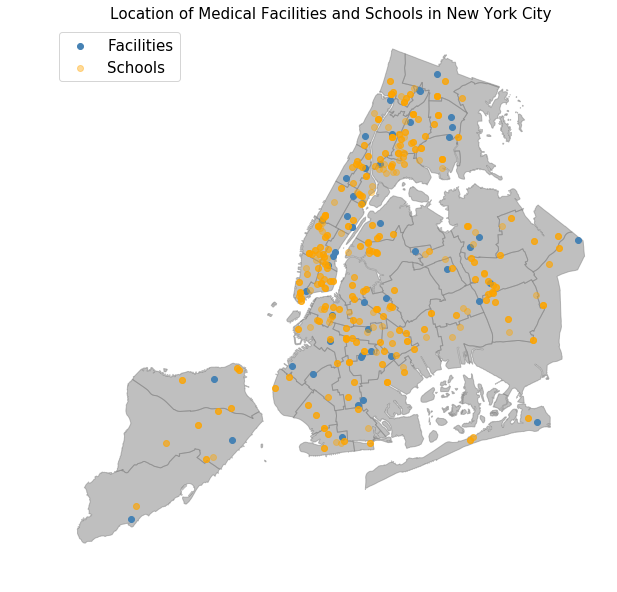

In [1082]:
ax = pl.figure(figsize=(10, 10)).add_subplot(111)
ax.axis('off')
pumashap.plot(ax=ax, color='grey', edgecolor='grey', alpha=0.5)
geofacilities.plot(ax=ax,column='facility_id', color='steelblue',lw=1)
schools.plot(ax=ax, column='DBN',color='orange', alpha=0.4, lw=1)
ax.set_title('Location of Medical Facilities and Schools in New York City', size=15)
leg = ['Facilities', 'Schools']
ax.legend(leg, fontsize=15, loc='upper left')

**Fig. 5** The map shows the locations of medical facilities and schools in New York City.

**5.2 join hospital facilities and PUMA data**

In [1083]:
#spatial join puma map and facility locations
pumafacilities = gp.sjoin(pumashap, geofacilities, op='contains')

In [1084]:
pumafacilities_ = pumafacilities[['puma','asthmaRatio','drugRatio']]

In [1085]:
pumafacilities_ = pumafacilities_.groupby('puma').mean()

In [1086]:
pumafacilities = pumashap.merge(pumafacilities_, on='puma')

In [1087]:
#spatial join puma map and school locations including crimes and SAT data
pumaschools = gp.sjoin(pumashap, schools,op='contains')

In [1088]:
pumaschools_ = pumaschools[['puma','Major N', 'Oth N',
                   'NoCrim N', 'Prop N', 'Vio N','AvgOfMajor N',
                   'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N','SATmath', 'SATall']]

In [1089]:
pumaschools_ = pumaschools_.groupby('puma').mean()

In [1090]:
pumaschools = pumashap.merge(pumaschools_, on='puma')

In [1091]:
alldata = pumaschools_.merge(pumafacilities_, on='puma').reset_index()

In [1092]:
alldata.to_csv("finalDataset.csv", index=False)
alldata.shape

(36, 15)

In [1093]:
alldata.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugRatio
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.036503,0.063314
1,3704,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,417.750000,409.125000,0.037053,0.032269
2,3705,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,377.567568,372.558559,0.044207,0.202915
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.054454,0.013583
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.057007,0.003671


## Add income data

In [1107]:
url = "https://www2.census.gov/programs-surveys/acs/data/pums/2016/5-Year/csv_hny.zip"
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x1c2705b2e8>)

In [1110]:
!unzip -d $puidata file.gz

Archive:  file.gz
  inflating: /Users/mkm/PUI2018/ss16hny.csv  
  inflating: /Users/mkm/PUI2018/ACS2012_2016_PUMS_README.pdf  


In [1114]:
income = pd.read_csv(os.getenv('PUIDATA') + "/ss16hny.csv")

In [1115]:
income = income[['PUMA','HINCP']]

In [1116]:
income.dropna(inplace=True)

In [1117]:
income.shape

(371535, 2)

In [1118]:
income = income.groupby('PUMA').mean()

In [1136]:
income.shape

(145, 1)

In [1137]:
pumaschools['puma'] = pumaschools['puma'].convert_objects(convert_numeric=True)

/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [1139]:
#merge income with puma schools data
incomesat = income.merge(pumaschools, left_on = income.index, right_on = 'puma')

# PART II Visual and Exploratory analysis and Modeling

## 6 checking collinearity and covariance of the data

**6.1 plot SAT features against each other and assess collinearity**

In [1158]:
cs = pd.DataFrame(schools)

In [1185]:
cs.shape

(411, 12)

In [1187]:
cs = cs.groupby('DBN').mean()

In [1188]:
cs[['SATmath','SATall']].corr()

,SATmath,SATall
SATmath,1.000000,0.953733
SATall,0.953733,1.000000


In [1189]:
#alldata[['SATmath','SATall']].corr()

Text(0.5, 0, 'SATmath')

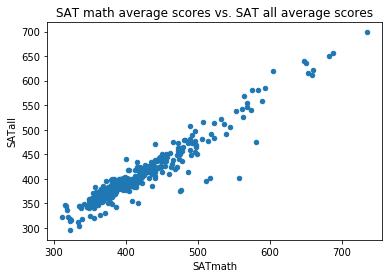

In [1190]:
cs.plot(x='SATmath', y='SATall',kind='scatter')
pl.title('SAT math average scores vs. SAT all average scores')
pl.ylabel("SATall");
pl.xlabel("SATmath")

**Fig.6** The scatter plot of average SAT all scores against SAT math average scores by DBN.

**Comment:** The scatter plot shows that SAT math average scores by DBN has a strong positively correlation with average SAT all scorres.

**6.2 plot the SAT feature by PUMA against 3 of the crime features**

In [1198]:
alldata[['SATmath','SATall','Major N','AvgOfMajor N','AvgOfNoCrim N']].corr()

,SATmath,SATall,Major N,AvgOfMajor N,AvgOfNoCrim N
SATmath,1.000000,0.944834,0.409596,0.642957,0.624824
SATall,0.944834,1.000000,0.442244,0.682967,0.656947
Major N,0.409596,0.442244,1.000000,0.505400,0.445661
AvgOfMajor N,0.642957,0.682967,0.505400,1.000000,0.991419
AvgOfNoCrim N,0.624824,0.656947,0.445661,0.991419,1.000000


/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


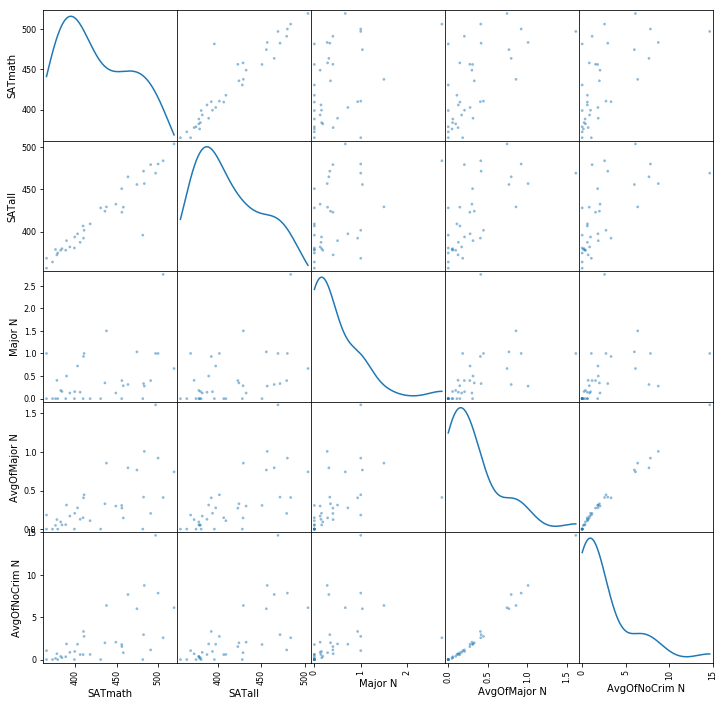

In [1181]:
fig = pd.scatter_matrix(alldata[['SATmath','SATall','Major N','AvgOfMajor N','AvgOfNoCrim N']], s=30, figsize=(12, 12), diagonal='kde')

**Fig.7** The scatter plot matrix shows the correlation among 2 SAT festures and 3 crime features.

**Comment:** Both SAT mat hand SAT average all scores have a weakly positive correlation with the number of major crime, and more positive correlation with both the average number of major crimes and the average number of non-criminal crimes. Through the matrix, we can also observe a strong positive correlation between the average number of major crimes and the average number of non-criminal crimes.

**6.3 plot the SAT feature against medical data**

In [1195]:
alldata[['SATmath','SATall','asthmaRatio', 'drugRatio']].corr()

,SATmath,SATall,asthmaRatio,drugRatio
SATmath,1.000000,0.944834,-0.513425,-0.192345
SATall,0.944834,1.000000,-0.496018,-0.129519
asthmaRatio,-0.513425,-0.496018,1.000000,0.082830
drugRatio,-0.192345,-0.129519,0.082830,1.000000


/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


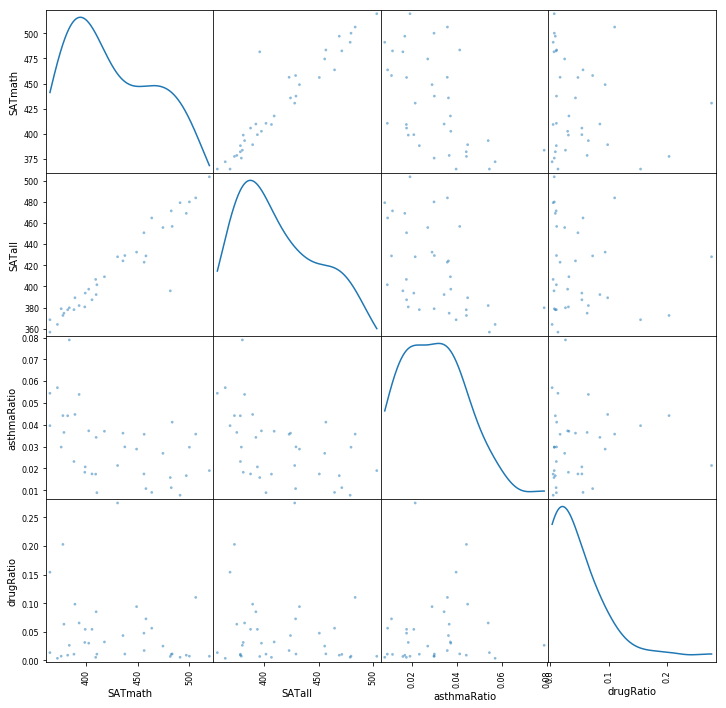

In [1194]:
fig = pd.scatter_matrix(alldata[['SATmath','SATall','asthmaRatio', 'drugRatio']], s=30, figsize=(12, 12), diagonal='kde')

**Fig.8** The scatter plot matrix shows the correlation among 2 SAT festures and 2 medical features.

**Comment:** Both SAT math score and SAT average all score have a very weakly negative correlation with the drug ratio, and a negative correlation with asthma ratio. Through the matrix, we can also observe that there is almost no correlation between asthma ratio and drug ratio.

**Extra: plot the SAT feature against income data**

In [1199]:
incomesat[['HINCP','SATmath','SATall']].corr()

,HINCP,SATmath,SATall
HINCP,1.000000,0.456977,0.529993
SATmath,0.456977,1.000000,0.954615
SATall,0.529993,0.954615,1.000000


/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


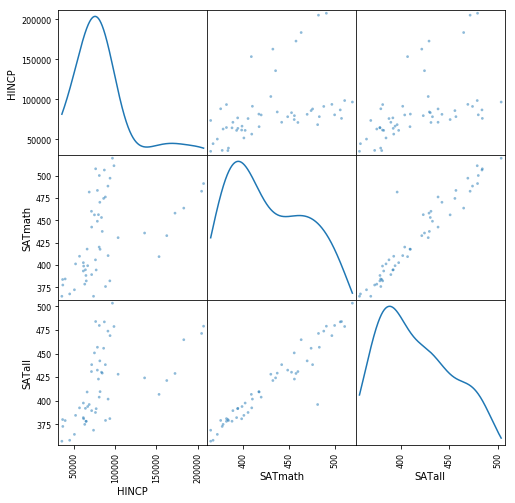

In [1206]:
fig = pd.scatter_matrix(incomesat[['HINCP','SATmath','SATall']], s=30, figsize=(8, 8), diagonal='kde')

**Fig.9** The scatter plot matrix shows the correlation among 2 SAT festures against income data.

**Comment:** Both SAT math score and SAT average all score have a weakly positive correlation with houshold income.

**plot a covariance matrix of all features**

In [1224]:
allin = alldata_income.drop('puma', axis=1)

Text(0.5, 1.0, 'covariance matrix')

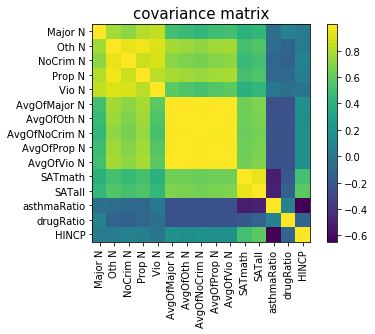

In [1230]:
ax = pl.figure().add_subplot(111)
cax = ax.imshow(allin.corr())
pl.colorbar(cax)
ax.set_xticks(range(len(allin.T)))
ax.set_xticklabels(allin, rotation=90)
ax.set_yticks(range(len(allin.T)))
ax.set_yticklabels(allin);
ax.set_title('covariance matrix', fontsize=15)

**Fig.10** The covariance matrix shows that despite the yellow diagnoal area(variable against itself), SAT features have very strong positive correlation with each other, and both of them have strong positive correlation with crime data, stronger with average crime data than individual crime data. Both SAT features have a weak positive correlation with household income.
Other than SAT features, the five AVERAGE crime features have very strong postiive correlation with each other as well. Another five crime features have strong postivie correlation with each other as well. The crime data almost have no correlation with medical data and household income.

## 7 Mapping 

**SAT Features**

(905464.7392303481, 1075092.8783844009, 112485.76061615368, 280480.4146439226)

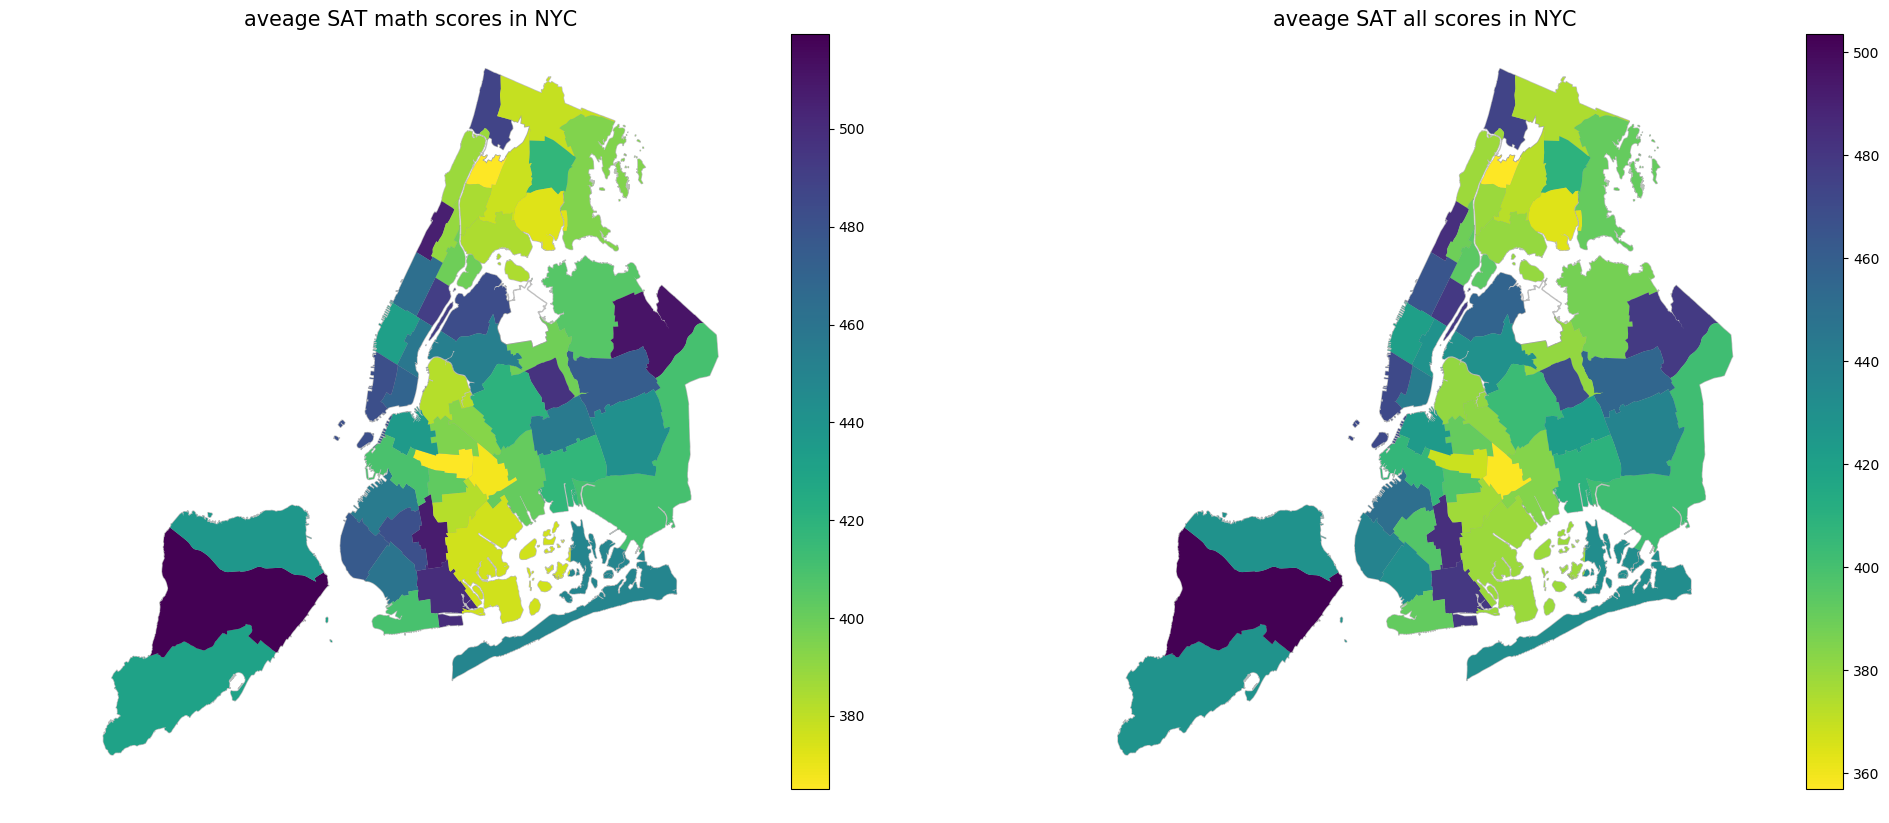

In [1233]:
fig = pl.figure(figsize=(24,10), dpi=100)
ax1 = fig.add_subplot(121)
pumashap.plot(ax=ax1, color='white', edgecolor='grey', alpha=0.5)
pumaschools.plot(column='SATmath', ax=ax1,legend=True, cmap ='viridis_r')
ax1.set_title('aveage SAT math scores in NYC', fontsize=15)
ax2 = fig.add_subplot(122)
pumashap.plot(ax=ax2, color='white', edgecolor='grey', alpha=0.5)
pumaschools.plot(column='SATall', ax=ax2, legend =True, cmap ='viridis_r')
ax2.set_title('aveage SAT all scores in NYC',fontsize=15)
ax1.axis('off')
ax2.axis('off')

**Fig.11** The choropleths represent the average SAT math score and the average SAT all score in New York City. Areas like State Island, College Point,  Bay Terrace in Queens, Midwood in Brooklyn and Manhattan have both high average SAT math score and high average SAT all scores. Since there is a strong positive correlation between two SAT features, two maps have no obvious difference.

(905464.7392303485, 1075092.8783844009, 112485.7606161537, 280480.4146439226)

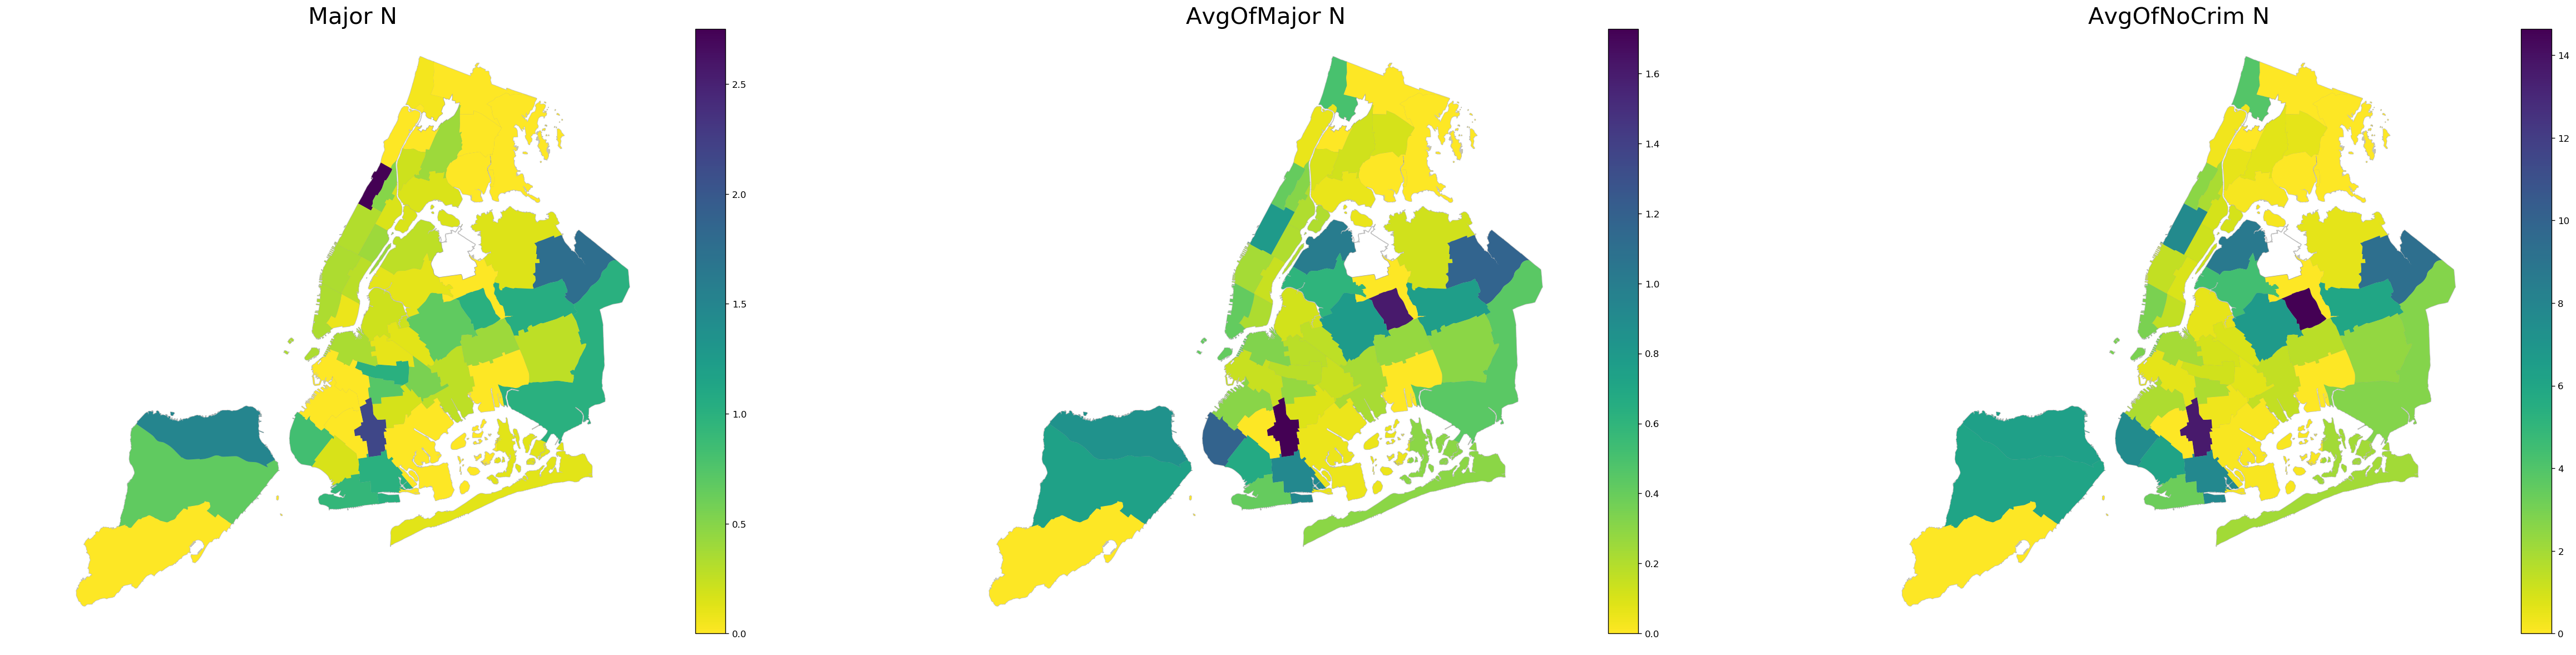

In [1433]:
fig = pl.figure(figsize=(50,12), dpi=120)
ax1 = fig.add_subplot(131)
pumashap.plot(ax=ax1, color='white', edgecolor='grey', alpha=0.5)
pumaschools.plot(column='Major N', ax=ax1,legend=True, cmap ='viridis_r')
ax1.set_title('Major N', fontsize =25)
ax2 = fig.add_subplot(132)
pumashap.plot(ax=ax2, color='white', edgecolor='grey', alpha=0.5)
pumaschools.plot(column='AvgOfMajor N', ax=ax2, legend =True, cmap ='viridis_r')
ax2.set_title('AvgOfMajor N', fontsize =25)
ax3 = fig.add_subplot(133)
pumashap.plot(ax=ax3, color='white', edgecolor='grey', alpha=0.5)
pumaschools.plot(column='AvgOfNoCrim N', ax=ax3, legend =True, cmap ='viridis_r')
ax3.set_title('AvgOfNoCrim N', fontsize =25)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

**Fig.12** The choropleths represent the number of major crime, the average number of major crime, and the average number of non-criminal crime in NYC. Areas like Flatbush in Brooklyn and Elmhurst in Queens have relatively higher number of crimes in general. Most of areas Mnahattan, Brooklyn and Bronx have low number of cirmes in general. Since there is a strong positive correlation between two average cirme data, two maps have no obvious difference.

(905464.7392303483, 1075092.8783844006, 112485.7606161537, 280480.4146439226)

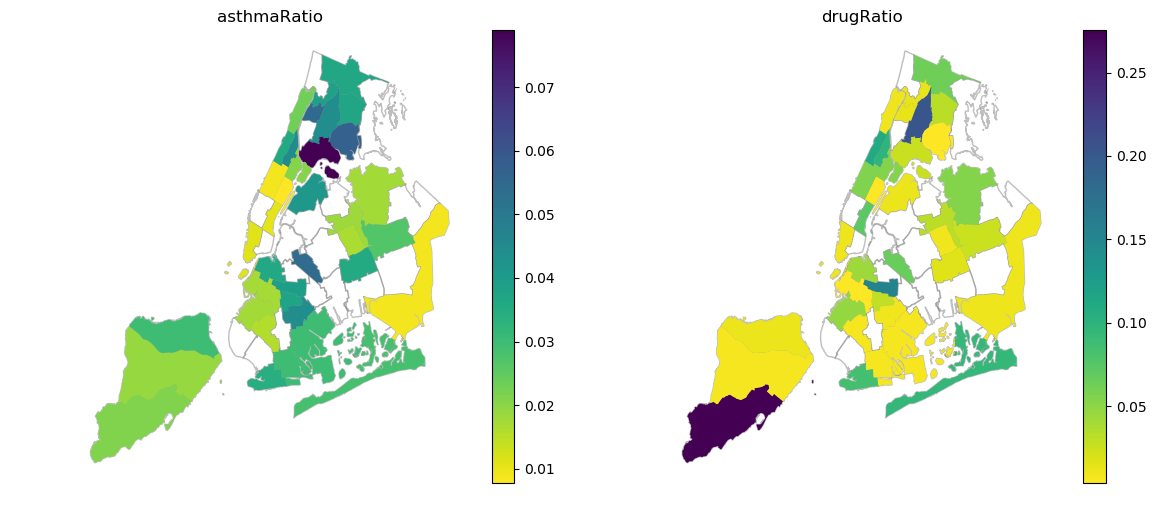

In [263]:
#pumafacilities_temp = gp.sjoin(pumashap, geofacilities, op='contains',how='left')
fig = pl.figure(figsize=(14,6), dpi=100)
ax1 = fig.add_subplot(121)
pumashap.plot(ax=ax1, color='white', edgecolor='grey', alpha=0.5)
pumafacilities.plot(column='asthmaRatio', ax=ax1,legend=True, cmap ='viridis_r')
ax1.set_title('asthmaRatio')
ax2 = fig.add_subplot(122)
pumashap.plot(ax=ax2, color='white', edgecolor='grey', alpha=0.5)
pumafacilities.plot(column='drugRatio', ax=ax2, legend =True, cmap ='viridis_r')
ax2.set_title('drugRatio')
ax1.axis('off')
ax2.axis('off')

**Fig.13** The choropleths represent the asthma ratio and drug ratio in NYC. White space means missing data entry in that area. There is no correlation between asthma ratio and drug ratio. Asthma Ratio is high in Hunter Point at Bronx, and drug ratio is high in Pleasant Plains in Staten Island. 

In [1434]:
pumashap['puma'] = pumashap['puma'].convert_objects(convert_numeric=True)
pumaincome = pumashap.merge(income, left_on='puma', right_on=income.index)

/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


(905464.7392303481, 1075092.8783844009, 112485.7606161537, 280480.41464392265)

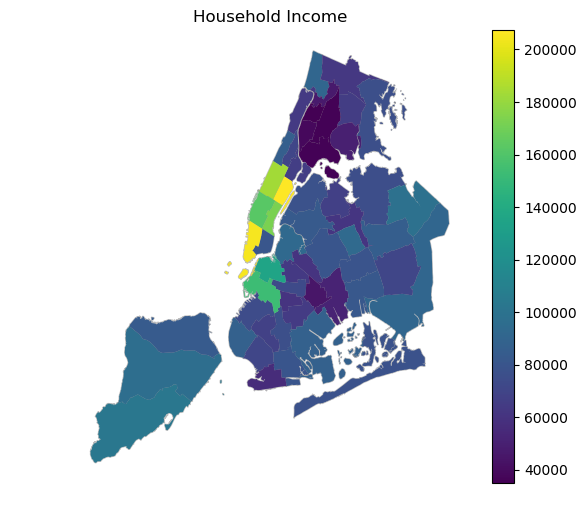

In [776]:
fig = pl.figure(figsize=(14,6), dpi=100)
ax1 = fig.add_subplot(121)
pumashap.plot(ax=ax1, color='white', edgecolor='grey', alpha=0.5)
pumaincome.plot(column='HINCP', ax=ax1,legend=True, cmap ='viridis')
ax1.set_title('Household Income')
ax1.axis('off')

**Fig.14** The choropleth represents the distributon of household income in NYC. Manhattan has the highest percentile of household income, and Bronx has lower household income, while the rest is at average.

## 8 start with linear modeling 

**8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature**

**Predicting SAT Math**

In [1435]:
X = alldata[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N']]
#X = sm.add_constant(X)
X = preprocessing.scale(X)

In [1436]:
y_math = alldata['SATmath']
y_math = preprocessing.scale(y_math)

In [1437]:
mod1 =sm.OLS(y_math, X).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     2.520
Date:                Mon, 17 Dec 2018   Prob (F-statistic):             0.0285
Time:                        17:02:46   Log-Likelihood:                -38.885
No. Observations:                  36   AIC:                             97.77
Df Residuals:                      26   BIC:                             113.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8614      0.588      1.464      0.1

**Predicting SAT All average**

In [1438]:
y_all = alldata['SATall']
y_all = preprocessing.scale(y_all)

In [1439]:
mod2 =sm.OLS(y_all, X).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     3.190
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00844
Time:                        17:02:49   Log-Likelihood:                -36.671
No. Observations:                  36   AIC:                             93.34
Df Residuals:                      26   BIC:                             109.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9304      0.553      1.681      0.1

**Comment:** The fist model uses 10 crime data features to predict SAT math score, while the second one is to predict SAT all average score. The second model has R-2 of 55.1% and an adj. R-2 of 37.8%, which is better than the first one. All of the independent variables have p-value larger than 0.05, which indicates that they do not influence the independent variable significantly. 

**8.2 add drugs and asthma discharge data and create a new multilinear model**

**Predicting SAT Math**

In [351]:
X = alldata[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N','asthmaRatio', 'drugRatio']]
X = sm.add_constant(X)
X = preprocessing.scale(X)

In [352]:
mod3 =sm.OLS(y_math, X).fit()
print(mod3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     3.775
Date:                Sun, 16 Dec 2018   Prob (F-statistic):            0.00272
Time:                        17:00:16   Log-Likelihood:                -31.995
No. Observations:                  36   AIC:                             87.99
Df Residuals:                      24   BIC:                             107.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

/Users/mkm/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/mkm/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/mkm/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/mkm/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/mkm/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


**Predicting SAT All average**

In [353]:
mod4 =sm.OLS(y_all, X).fit()
print(mod4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     4.141
Date:                Sun, 16 Dec 2018   Prob (F-statistic):            0.00149
Time:                        17:00:17   Log-Likelihood:                -30.890
No. Observations:                  36   AIC:                             85.78
Df Residuals:                      24   BIC:                             104.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

**Comment:** The fist model uses 10 crime data features and 2 medical data features to predict SAT math score, while the second one is to predict SAT all average score. The second model has R-2 of 67.4% and an adj. R-2 of 51.1%, which is better than the first one. Also, this model is better than the previous one using only crime data. Only asthma ratio has p-value smaller than 0.05, indicating that it influences the SAT score significantly.

**Extra: add income data and create a new multilinear model**

In [818]:
alldata['puma'] = alldata['puma'].convert_objects(convert_numeric=True)
alldata_income = alldata.merge(income, left_on='puma', right_on=income.index)

/Users/mkm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [819]:
X = alldata_income[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N','asthmaRatio', 'drugRatio', 'HINCP']]
#X = sm.add_constant(X)
X = preprocessing.scale(X)

In [820]:
y_math = alldata_income['SATmath']
y_math = preprocessing.scale(y_math)

In [821]:
mod5 =sm.OLS(y_math, X).fit()
print(mod5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     6.025
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           9.84e-05
Time:                        18:38:07   Log-Likelihood:                -24.391
No. Observations:                  36   AIC:                             74.78
Df Residuals:                      23   BIC:                             95.37
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0888      0.435      2.505      0.0

In [822]:
y_all = alldata_income['SATall']
y_all = preprocessing.scale(y_all)

In [823]:
mod6 =sm.OLS(y_all, X).fit()
print(mod6.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     10.94
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           6.06e-07
Time:                        18:38:09   Log-Likelihood:                -15.595
No. Observations:                  36   AIC:                             57.19
Df Residuals:                      23   BIC:                             77.78
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0702      0.340      3.144      0.0

**Comment:** The fist model uses 10 crime data features, 2 medical data features, and household income to predict SAT math score, while the second one is to predict SAT all average score. The second model has R-2 of 86.1% and an adj. R-2 of 78.2%, which is better than the first one. Also, this model is better than the previous one using only crime data and medical data. Both average number of violent crime and household income have p-value smaller than 0.05, indicating that they have significant influence.

## 9 compare the linear models:

**Predicting SAT math score**
- Null Hypothesis: the likelihood test of the model using crime data and the one using both crime and medical data has statistic same or larger than critical value.
- alpha = 0.05

In [848]:
mod3.compare_lr_test(mod1)

(13.780169476117592, 0.0010178275886070123, 2.0)

In [1440]:
alpha = 0.05
print ("LR : ", -2 * (mod3.llf - (mod1.llf)))
print ("LR from statsmodels:", mod3.compare_lr_test(mod1))
LR = mod3.compare_lr_test(mod1)

print ("We ")
if LR[0] < 5.99: #0.05 level for 2 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis")
print ("p < %.3f"%alpha)

LR :  -13.780169476117607
LR from statsmodels: (13.780169476117607, 0.001017827588607005, 2.0)
We 
reject the Null hypothesis
p < 0.050


**Predicting SAT All Average**
- Null Hypothesis: the likelihood test of the model using crime data and the one using both crime and medical data has statistic same or larger than critical value.
- alpha = 0.05

In [1442]:
mod4.compare_lr_test(mod2)

(11.563347046414926, 0.003083550694159665, 2.0)

In [1443]:
alpha = 0.05
print ("LR : ", -2 * (mod4.llf - (mod2.llf)))
print ("LR from statsmodels:", mod4.compare_lr_test(mod2))
LR = mod4.compare_lr_test(mod2)

print ("We ")
if LR[0] < 5.99: #0.05 level for 2 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis")
print ("p < %.3f"%alpha)

LR :  -11.563347046414926
LR from statsmodels: (11.563347046414926, 0.003083550694159665, 2.0)
We 
reject the Null hypothesis
p < 0.050


**Comment:** The hypothesis testings of likelihood ratio test show that the complicated model(including medical data) is better than the simple one on predicting both SAT math score and SAT all average score.

**Compare the model including income data to the previous two models**

**Predicting SAT math score**
- Null Hypothesis: the likelihood test of the model using crime and medical data only and the one adding household income data has statistic large than critical value.
- alpha = 0.05

In [1446]:
mod5.compare_lr_test(mod3) 

(15.207896030854172, 9.62999186431892e-05, 1.0)

In [1447]:
alpha = 0.05
print ("LR : ", -2 * (mod5.llf - (mod3.llf)))
print ("LR from statsmodels:", mod4.compare_lr_test(mod2))
LR = mod6.compare_lr_test(mod4)

print ("We ")
if LR[0] < 3.84: #0.05 level for 1 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis")
print ("p < %.3f"%alpha)

LR :  -15.207896030854172
LR from statsmodels: (11.563347046414926, 0.003083550694159665, 2.0)
We 
reject the Null hypothesis
p < 0.050


**Predicting SAT All average score**
- Null Hypothesis: the likelihood test of the model using crime and medical data only and the one adding household income data has statistic large than critical value.
- alpha = 0.05

In [1448]:
mod6.compare_lr_test(mod4)

(30.589457980267575, 3.1882137254609185e-08, 1.0)

In [1449]:
alpha = 0.05
print ("LR : ", -2 * (mod5.llf - (mod3.llf)))
print ("LR from statsmodels:", mod4.compare_lr_test(mod2))
LR = mod6.compare_lr_test(mod2)

print ("We ")
if LR[0] < 7.81: #0.05 level for 3 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis")
print ("p < %.3f"%alpha)

LR :  -15.207896030854172
LR from statsmodels: (11.563347046414926, 0.003083550694159665, 2.0)
We 
reject the Null hypothesis
p < 0.050


**Comment:** 
- The hypothesis testings of likelihood ratio test show that the complicated model(including household income data) is better than the simple one on predicting both SAT math score and SAT all average score. 
- The model including all dataset to predict SAT all average score has the best performance.

## 10 random forest regression on school-related data only

**10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features**

In [1450]:
X = alldata[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N']]
X = preprocessing.scale(X)

In [1451]:
y = alldata['SATall']
y = preprocessing.scale(y)

In [1452]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

24
12
24
12


In [1695]:
# Supervised transformation based on random forests
rf = rfc(max_depth=3, n_estimators=100, random_state=143)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [1696]:
train_score = rf.score(X_train, y_train)
print(f'Train data R-2 score: {train_score:>5.3}')

Train data R-2 score:   0.9


In [1697]:
test_score = rf.score(X_test, y_test)
print(f'Test data R-2 score: {test_score:>5.3}')

Test data R-2 score: 0.633


Feature ranking:
1. feature 1 (0.373255)
2. feature 5 (0.234643)
3. feature 2 (0.154749)
4. feature 3 (0.107597)
5. feature 4 (0.093268)
6. feature 0 (0.036488)


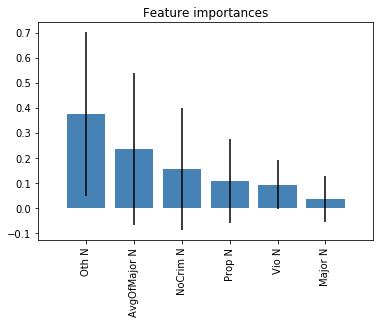

In [1698]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

label = alldata.iloc[:,1:11]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
pl.figure()
pl.title("Feature importances")
pl.bar(range(X_test.shape[1]), importances[indices],
       color="steelblue", yerr=std[indices], align="center")
pl.xticks(range(X_test.shape[1]), label.columns[indices], rotation=90)
pl.xlim([-1, X_test.shape[1]])

pl.show()

**Comment:** The 3 most predictive features in this random forest model are the number of other crimes, the average number of major crimes, and the number of crimes. The R-2 of train data is 0.9, and the R-2 test data is 0.633. The difference is 0.277, meaning that the model is a little overfitted. We can use cross-validation to mitigate the problem.

## 11 random forest with crime and medical (and income if you have it) features

**11.1 create a random forest model that only uses the 3 most predictive features about school crimes, the health features and income**

In [1699]:
X_ = alldata_income[['NoCrim N', 'AvgOfMajor N','Oth N', 'asthmaRatio', 'drugRatio','HINCP']]
X = preprocessing.scale(X_)

In [1700]:
y = alldata['SATall']
y = preprocessing.scale(y)

In [1701]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

24
12
24
12


In [1702]:
# Supervised transformation based on random forests
rf = rfc(max_depth=3, n_estimators=100,random_state=888)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

**11.2 evaluate the performance of the model**

In [1703]:
train_score = rf.score(X_train, y_train)
print(f'Train data R-2 score: {train_score:>5.3}')

Train data R-2 score: 0.927


In [1706]:
test_score = rf.score(X_test, y_test)
print(f'Test data R-2 score: {test_score:>5.3}')

Test data R-2 score: 0.305


**11.3 discuss the importance of each feature in the model**

Feature ranking:
1. feature 1 (0.375270)
2. feature 2 (0.242921)
3. feature 5 (0.193878)
4. feature 0 (0.117046)
5. feature 3 (0.044415)
6. feature 4 (0.026470)


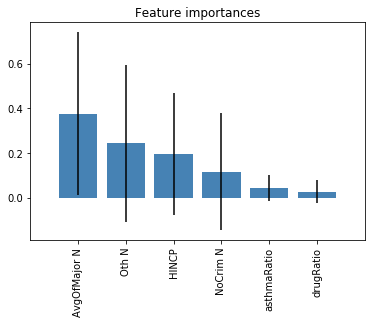

In [1705]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

label = X_

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
pl.figure()
pl.title("Feature importances")
pl.bar(range(X_test.shape[1]), importances[indices],
       color="steelblue", yerr=std[indices], align="center")
pl.xticks(range(X_test.shape[1]), label.columns[indices], rotation=90)
pl.xlim([-1, X_test.shape[1]])

pl.show()

**Comment:** The 3 most predictive features in this random forest model are the average number of major crimes, the number of other crimes, and household income. The R-2 of train data is 0.92, and the R-2 test data is 0.30. The difference is 0.6, meaning that the model is overfitted. We can use cross-validation to mitigate the problem.